Imports

In [3]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap
import os
import sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.explainability import (
    plot_builtin_feature_importance,
    shap_global_explanation,
    shap_force_plot
)


c:\Users\Kal\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Data & Model

In [4]:
df = pd.read_csv("../data/processed/fraud_processed.csv")

X = df.drop(columns=["class"])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

rf_model = load("../models/random_forest_model.pkl")


Built-in Feature Importance

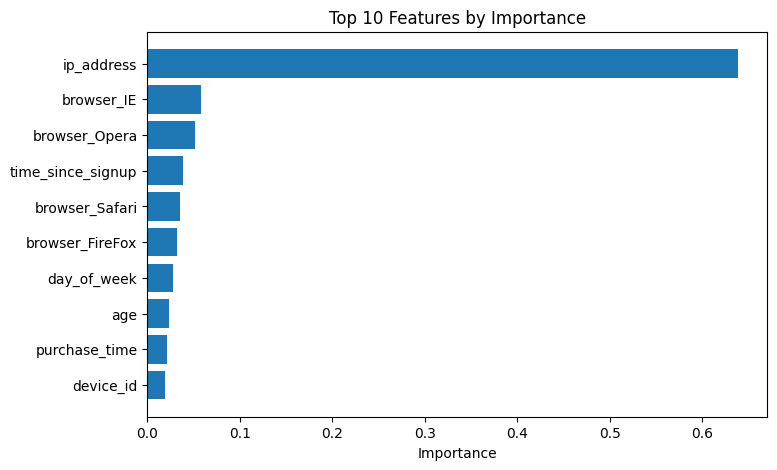

In [10]:
import matplotlib.pyplot as plt
def plot_builtin_feature_importance(model, feature_names, top_n=10):
    importances = model.feature_importances_
    
    # Check if the lengths match
    if len(feature_names) != len(importances):
        print("Warning: Feature names and importances do not match in length.")
        # Handle the discrepancy (e.g., truncate the list or pad it)
        min_len = min(len(feature_names), len(importances))
        feature_names = feature_names[:min_len]
        importances = importances[:min_len]
    
    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)
    
    plt.figure(figsize=(8, 5))
    plt.barh(fi["feature"][:top_n][::-1], fi["importance"][:top_n][::-1])
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Features by Importance")
    plt.show()

# Example usage:
top_features = plot_builtin_feature_importance(
    rf_model,
    X_train.columns,
    top_n=10
)

SHAP Global Explanation

In [12]:
X_train_model = X_train.drop(
    columns=["signup_time", "purchase_time", "device_id"]
)
X_shap = X_train_model.sample(500, random_state=42)

explainer = shap.TreeExplainer(
    rf_model,
    feature_perturbation="tree_path_dependent"
)

shap_values = explainer.shap_values(
    X_shap,
    check_additivity=False
)


Identify TP / FP / FN Cases

In [14]:
# 1. Prepare test features EXACTLY like training
X_test_model = X_test.drop(
    columns=["signup_time", "purchase_time", "device_id"]
)

# 2. Predict using model-ready features
y_pred = rf_model.predict(X_test_model)

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 4. Build results table (keep index alignment)
results = X_test_model.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred

# 5. Get one example of each case
tp = results[(results.y_true == 1) & (results.y_pred == 1)].index[0]
fp = results[(results.y_true == 0) & (results.y_pred == 1)].index[0]
fn = results[(results.y_true == 1) & (results.y_pred == 0)].index[0]


SHAP Force Plots (MANDATORY)

In [31]:
X_test_model = X_test.drop(
    columns=["signup_time", "purchase_time", "device_id"]
)


def shap_waterfall_local(explainer, X, idx):
    x_row = X.loc[[idx]]  # keep 2D shape for explainer
    shap_vals = explainer.shap_values(x_row, check_additivity=False)

    # Binary classifier
    if isinstance(shap_vals, list):
        # Already split by class
        values = shap_vals[1][0]  # first row of class 1
        base = explainer.expected_value[1]
    else:
        # shap_vals is 2D array: (n_features, n_classes)
        # Pick column 1 (fraud)
        values = shap_vals[0][:, 1]  # shape = (n_features,)
        base = explainer.expected_value[1]

    shap.waterfall_plot(
        shap.Explanation(
            values=values,
            base_values=base,
            data=x_row.iloc[0],
            feature_names=X.columns
        )
    )




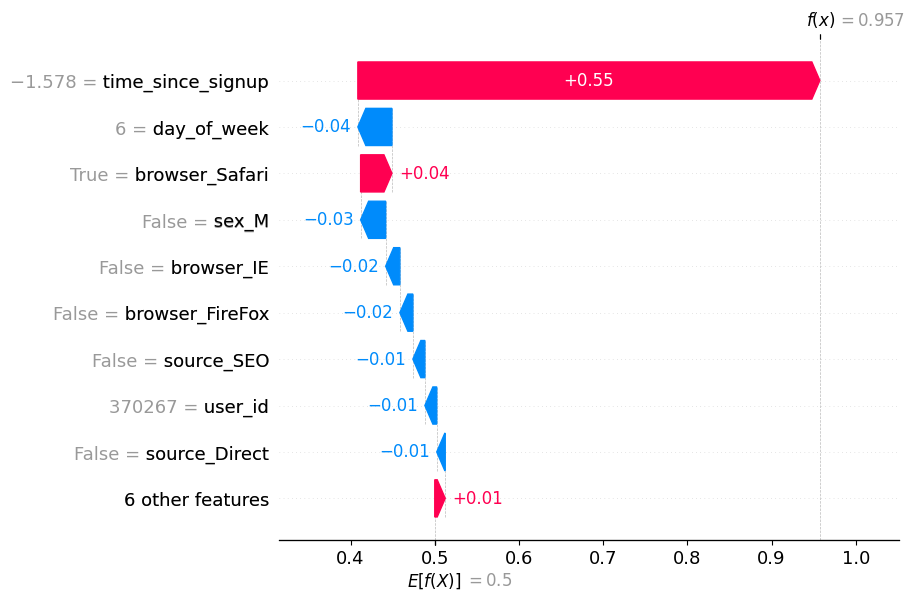

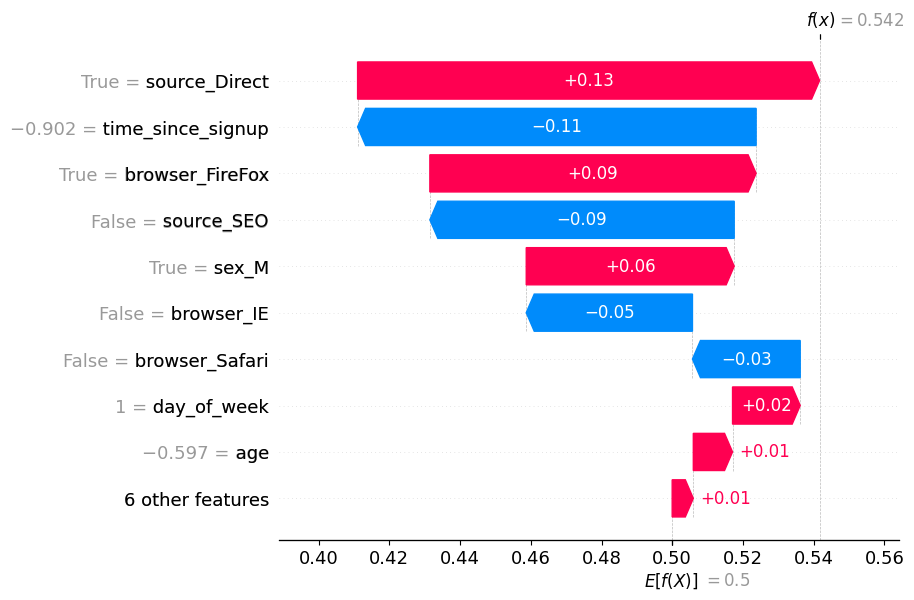

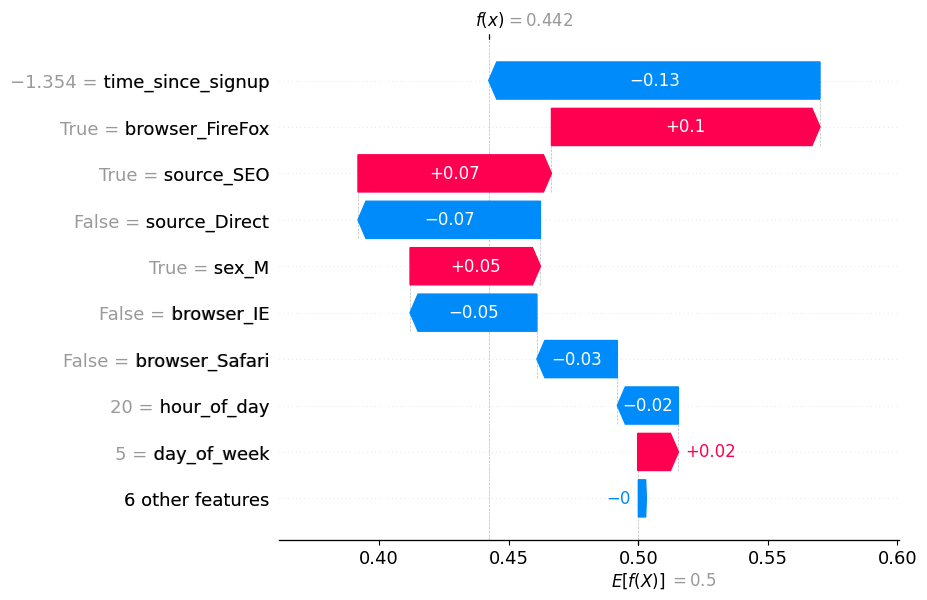

In [33]:
# True Positive
shap_waterfall_local(explainer, X_test_model, tp)

# False Positive
shap_waterfall_local(explainer, X_test_model, fp)

# False Negative
shap_waterfall_local(explainer, X_test_model, fn)
